<a href="https://colab.research.google.com/github/DB11051998/Pothole-Detection/blob/master/RCNN_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# as you can see current ram is 12GB only, to increase it run below code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os
import cv2
import keras
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [2]:
cd /content/drive/My Drive/pothole

/content/drive/My Drive/pothole


In [3]:
train_images=np.load('/content/drive/My Drive/pothole/train_image.np.npy')
train_labels=np.load('/content/drive/My Drive/pothole/train_labels.np.npy')

In [4]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [6]:
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(input = vggmodel.input, output = predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [8]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(train_labels)

In [9]:
X_train, X_test , y_train, y_test = train_test_split(train_images,Y,test_size=0.10)

In [10]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [11]:
del X_train,X_test,y_train,y_test

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [14]:

hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/100
10/10 [==============================] - 10s 1000ms/step - loss: 1.0604 - accuracy: 0.7531 - val_loss: 0.6939 - val_accuracy: 0.7344

Epoch 00001: val_loss improved from inf to 0.69392, saving model to ieeercnn_vgg16_1.h5
Epoch 2/100
10/10 [==============================] - 1s 143ms/step - loss: 0.3939 - accuracy: 0.8156 - val_loss: 0.6967 - val_accuracy: 0.7656

Epoch 00002: val_loss did not improve from 0.69392
Epoch 3/100
10/10 [==============================] - 3s 305ms/step - loss: 0.3332 - accuracy: 0.8656 - val_loss: 0.2326 - val_accuracy: 0.9062

Epoch 00003: val_loss improved from 0.69392 to 0.23261, saving model to ieeercnn_vgg16_1.h5
Epoch 4/100
10/10 [==============================] - 2s 236ms/step - loss: 0.3104 - accuracy: 0.8625 - val_loss: 0.5814 - val_accuracy: 0.8438

Epoch 00004: val_loss did not improve from 0.23261
Epoch 5/100
10/10 [==============================] - 3s 345ms/step - loss: 0.4390 - accuracy: 0.7937 - val_loss: 0.1617 - val_accuracy: 0.89

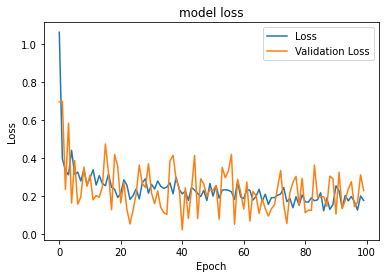

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')


In [ ]:
train_images

array([[[[ 64,  61,  70],
         [ 60,  57,  66],
         [ 58,  55,  64],
         ...,
         [183, 177, 182],
         [193, 187, 192],
         [203, 197, 202]],

        [[ 64,  61,  70],
         [ 60,  57,  66],
         [ 58,  55,  64],
         ...,
         [183, 177, 182],
         [193, 187, 192],
         [203, 197, 202]],

        [[ 88,  85,  94],
         [109, 106, 115],
         [129, 126, 135],
         ...,
         [168, 162, 167],
         [177, 171, 176],
         [186, 180, 185]],

        ...,

        [[105, 111, 122],
         [109, 117, 129],
         [114, 122, 135],
         ...,
         [131, 126, 128],
         [132, 127, 129],
         [132, 127, 129]],

        [[ 59,  65,  78],
         [ 72,  79,  92],
         [ 85,  93, 106],
         ...,
         [135, 130, 132],
         [136, 131, 133],
         [138, 133, 135]],

        [[ 59,  65,  78],
         [ 72,  79,  92],
         [ 85,  93, 106],
         ...,
         [135, 130, 132],
        

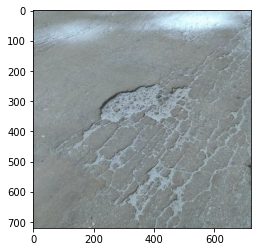

In [18]:
plt.imshow(cv2.imread('/content/drive/My Drive/pothole/images/img-1.jpg'))

not plane


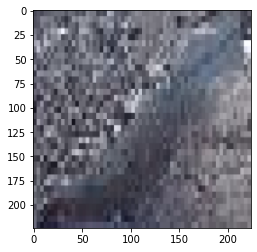

In [16]:

im = train_images[10]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

In [23]:
import cv2
cv2.setUseOptimized(True)

In [24]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

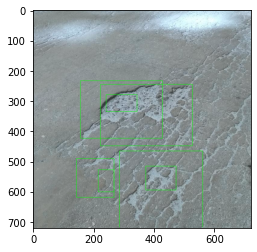

In [32]:

z=0
for e,i in enumerate(os.listdir('/content/drive/My Drive/pothole/images/')):
    if i.startswith("img-1."):
        z += 1
        img = cv2.imread(os.path.join('/content/drive/My Drive/pothole/images/',i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

        plt.figure()
        plt.imshow(imout)